Установим все необходимые библиотеки:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Работать будем с Tensorflow 2.

Внесём основные настройки, чтобы было удобнее их перебирать в дальнейшем:

In [27]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = 'input/'
PATH = "working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA

Для начала ознакомимся с нашими данными:

In [3]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [5]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [6]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['.ipynb_checkpoints', 'train', 'test_upload']


Распаковываем картинки. Выведем случайный пример изображений.

Случайное изображение


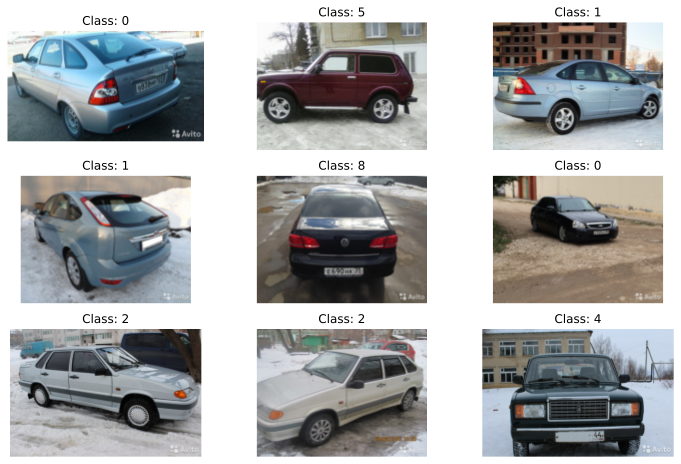

In [7]:
print('Случайное изображение')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

 Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.

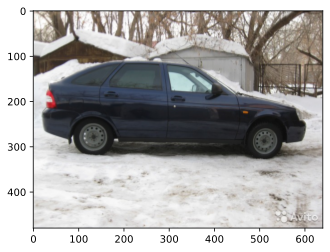

(640, 480)

In [8]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# АУГМЕНТАЦИЯ ДАННЫХ

Наверняка вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

Добавил более продвинутые библиотеки аугментации изображений (например, albumentations или imgaug. Для них есть специальные «обёртки» под Keras, например ImageDataAugmentor.

In [10]:
!pip install albumentations

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [11]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

# ГЕНЕРАЦИЯ ДАННЫХ

Завернём наши данные в генератор. 

In [13]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/usr/local/lib/python3.6/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/usr/local/lib/python3.6/dist-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


# СТРОИМ МОДЕЛЬ

Загружаем предобученную сеть Xception:

In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

Устанавливаем новую «голову» (head):

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Рекомендация. Попробуйте добавить Batch Normalization.

# ОБУЧАЕМ МОДЕЛЬ

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [45]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

Рекомендации: 

1. Добавьте другие функции из https://keras.io/callbacks/.

2. Используйте разные техники управления Learning Rate. Смотрите статьи на towardsdatascience и teleported.in (ENG).

Обучаем:

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/4
389/389 [==============================] - 2489s 6s/step - loss: 2.4647 - accuracy: 0.2453 - val_loss: 1.3610 - val_accuracy: 0.5312

Epoch 00001: saving model to best_model.hdf5
Epoch 2/4
389/389 [==============================] - 2477s 6s/step - loss: 1.7719 - accuracy: 0.3988 - val_loss: 1.1836 - val_accuracy: 0.5870

Epoch 00002: saving model to best_model.hdf5
Epoch 3/4
288/389 [=====================>........] - ETA: 8:41 - loss: 1.5643 - accuracy: 0.4662

In [ ]:
model.save('working/model_last.hdf5')
model.load_weights('best_model.hdf5')

Рекомендация. Попробуйте применить transfer learning с finetuning.

Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):

In [20]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

В итоге точность нашей модели составила 90,73 %. Учитывая, что классов десять, это очень хороший результат!

Посмотрим на графики обучения:

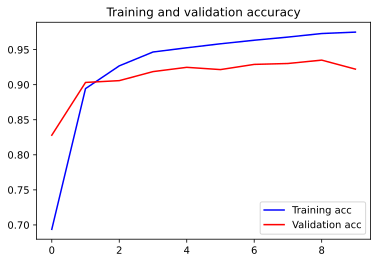

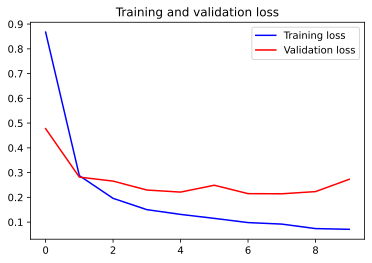

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Мы видим, что модель не дообучилась. 

Рекомендация. Попробуйте поставить больше эпох для обучения.

# Предсказываем на тестовых данных

In [23]:
test_sub_generator.samples

6675

In [24]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


209/209 [==============================] - 412s 2s/step


In [25]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


Рекомендация. Попробуйте добавить Test Time Augmentation (TTA). Подробнее читайте в статье на towardsdatascience.

In [26]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


Пора улучшать модель!

Как это сделать? Вспоминаем рекомендации из проекта:

- Примените transfer learning с finetuning.
- Настройте LR, optimizer, loss.

Подготовка данных:

- Подберите другие переменные (размер картинки, батч и так далее).
- Попробуйте разные способы заполнения пропусков c помощью Keras ImageDataGenerator.

Обучение модели:

- Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet.
- Добавьте Batch Normalization и поэкспериментируйте с архитектурой «головы».
- Примените другие функции callback в Keras.
- Попробуйте поставить больше эпох для обучения.

Продвинутый уровень:

- Добавьте TTA (Test Time Augmentation).
- Используйте разные техники управления Learning Rate. Ещё раз перечитайте статьи на towardsdatascience и teleported.in.
- Добавьте более продвинутые библиотеки аугментации изображений (например, albumentations или imgaug, для которых есть специальные «обёртки» под Keras, например ImageDataAugmentor).
- Используйте внешние датасеты для дообучения модели.
- Оберните вашу модель в сервис на Flask. Рекомендуем вам выполнить этот финальный шаг, чтобы на практике отследить особенности внедрения DL-моделей в продакшн.

